# CH08b Working_with_Efficient_Self-attention

In [9]:
!pip install transformers
!pip install py3nvml

We see the quadratic relationship $\mathcal{O}(n^2)$ between input sequence and peak memory usage, as the sequence length gets long. 
Let us check the memory usage and make sure no running processes

In [10]:
!nvidia-smi

Sun Jul  4 20:10:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Longformer

In [11]:
from transformers import LongformerTokenizer, LongformerModel
import torch
tokenizer = LongformerTokenizer.from_pretrained(
    'allenai/longformer-base-4096')
model = LongformerModel.from_pretrained(
    'allenai/longformer-base-4096')
sequence= "hello "*4093
inputs = tokenizer(sequence, return_tensors="pt")
print("input shape: ",inputs.input_ids.shape)
outputs = model(**inputs)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


input shape:  torch.Size([1, 4096])


As you pass a sequence whose length is more than 4096 you will get "IndexError: index out of range in self" 

In [12]:
# default attention window size is 512
# Window size refers to the size of an attention window around each token.
from transformers import LongformerConfig, \
     PyTorchBenchmark, PyTorchBenchmarkArguments
config_longformer=LongformerConfig.from_pretrained(
    "allenai/longformer-base-4096")
config_longformer_window4=LongformerConfig.from_pretrained(
    "allenai/longformer-base-4096", 
    attention_window=4)

In [13]:
sequence_lengths=[128,256,512,1024,2048,4096]
models=["config_longformer","config_longformer_window4"]
configs=[eval(m) for m in models]

In [14]:
benchmark_args = PyTorchBenchmarkArguments(
    sequence_lengths= sequence_lengths, 
    batch_sizes=[1], 
    models= models)
benchmark = PyTorchBenchmark(
    configs=configs, 
    args=benchmark_args)
results = benchmark.run()

1 / 2
2 / 2

====================       INFERENCE - SPEED - RESULT       ====================
--------------------------------------------------------------------------------
          Model Name             Batch Size     Seq Length     Time in s   
--------------------------------------------------------------------------------
      config_longformer              1              128            0.036     
      config_longformer              1              256            0.036     
      config_longformer              1              512            0.036     
      config_longformer              1              1024           0.065     
      config_longformer              1              2048           0.119     
      config_longformer              1              4096            0.23     
  config_longformer_window4          1              128            0.018     
  config_longformer_window4          1              256            0.022     
  config_longformer_window4          1      

In [1]:
import matplotlib.pyplot as plt 

def plotMe(results,title="Time"):
    plt.figure(figsize=(8,8))
    fmts= ["rs--","go--","b+-","c-o"]
    q=results.memory_inference_result
    if title=="Time": 
        q=results.time_inference_result
    models=list(q.keys())
    seq=list(q[models[0]]['result'][1].keys())
    models_perf=[list(q[m]['result'][1].values()) for m in models] 
    plt.xlabel('Sequence Length') 
    plt.ylabel(title) 
    plt.title('Inference Result') 
    for perf,fmt in zip(models_perf,fmts):
        plt.plot(seq, perf,fmt)
    plt.legend(models)  
    plt.show() 

Speed Test

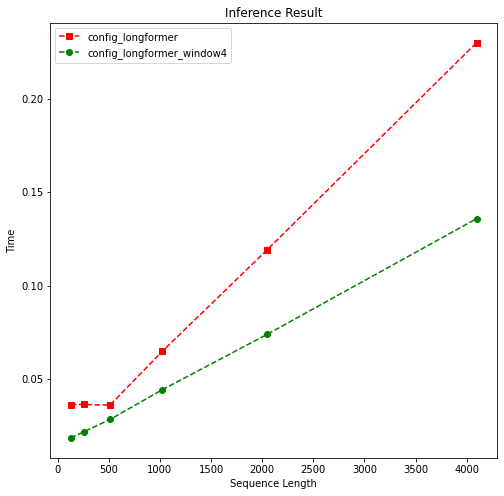

In [16]:
plotMe(results)

Memory Test

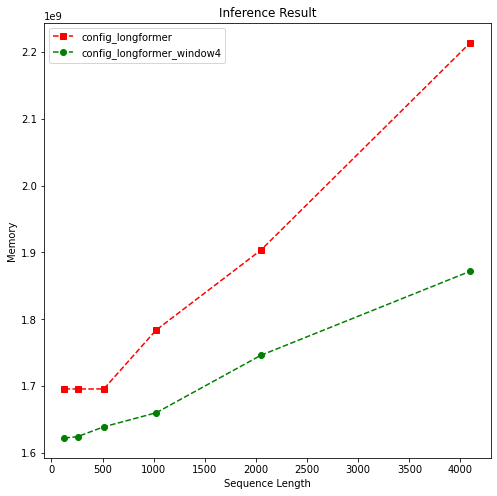

In [17]:
plotMe(results,"Memory")

## BigBird

In [1]:
# pip installs
!pip install transformers
!pip install py3nvml

In [2]:
from transformers import BigBirdConfig

# Default Bird  with num_random_blocks=3, block_size=64
sparseBird = BigBirdConfig.from_pretrained("google/bigbird-roberta-base")
# Fuyll attention Bird:
fullBird = BigBirdConfig.from_pretrained(
    "google/bigbird-roberta-base", 
    attention_type="original_full")

In [3]:
from transformers import PyTorchBenchmark, PyTorchBenchmarkArguments

In [4]:
sequence_lengths=[256,512,1024,2048, 3072, 4096]
models=["sparseBird","fullBird"]
configs=[eval(m) for m in models]

For smaller sequence lengths, The BigBird Model works with full-attention model due to block-size and seq-length inconsistency     

In [5]:
benchmark_args = PyTorchBenchmarkArguments(
    sequence_lengths=sequence_lengths,
    batch_sizes=[1],
    models=models)
benchmark = PyTorchBenchmark(
    configs=configs, 
    args=benchmark_args)
results = benchmark.run()

1 / 2


Attention type 'block_sparse' is not possible if sequence_length: 256 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3.Changing attention type to 'original_full'...
Attention type 'block_sparse' is not possible if sequence_length: 256 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3.Changing attention type to 'original_full'...
Attention type 'block_sparse' is not possible if sequence_length: 512 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffe

2 / 2

====================       INFERENCE - SPEED - RESULT       ====================
--------------------------------------------------------------------------------
          Model Name             Batch Size     Seq Length     Time in s   
--------------------------------------------------------------------------------
          sparseBird                 1              256            0.015     
          sparseBird                 1              512            0.028     
          sparseBird                 1              1024           0.088     
          sparseBird                 1              2048           0.224     
          sparseBird                 1              3072           0.213     
          sparseBird                 1              4096           0.274     
           fullBird                  1              256            0.012     
           fullBird                  1              512            0.021     
           fullBird                  1            

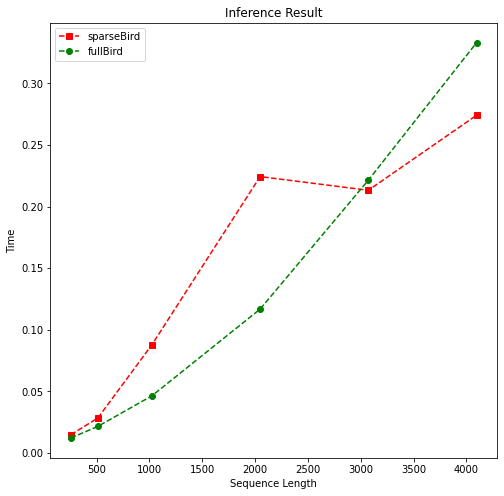

In [8]:
plotMe(results)

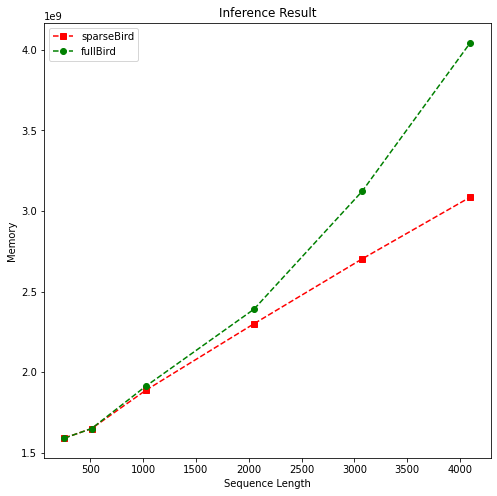

In [9]:
plotMe(results,"Memory")

# Reformer

In [2]:
# pip installs
!pip install transformers
!pip install py3nvml

In [3]:
from transformers import ReformerConfig, PyTorchBenchmark, PyTorchBenchmarkArguments

We will tweak some settings for the *Reformer* model to work in full-attention mode. When we set **lsh_attn_chunk_length**  and **local_attn_chunk_length** to 16384 which is maximum length that Reformer can process, in this case, the Reformer model will have no chance for local optimization and will automatically work like the vanilla transformers.

In [4]:
fullReformer = ReformerConfig.from_pretrained("google/reformer-enwik8",
                                               lsh_attn_chunk_length=16384, 
                                              local_attn_chunk_length=16384)
sparseReformer = ReformerConfig.from_pretrained("google/reformer-enwik8")

In [5]:
!nvidia-smi

Sun Jul  4 20:25:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
sequence_lengths=[256, 512, 1024, 2048, 4096, 8192, 12000]
models=["fullReformer","sparseReformer"]
configs=[eval(e) for e in models]

Indeed, Reformer can process the sequences up to length of 16384. Due to the accelerator capacity of our environment, the attention matrix does not fit on GPU, and we get CUDA out of memory warning.  

In [7]:
benchmark_args = PyTorchBenchmarkArguments(
    sequence_lengths=sequence_lengths,
    batch_sizes=[1],
    models=models)
benchmark = PyTorchBenchmark(
    configs=configs, 
    args=benchmark_args)
results = benchmark.run()

1 / 2
2 / 2


/usr/local/lib/python3.7/dist-packages/transformers/models/reformer/modeling_reformer.py:1164: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorCompare.cpp:255.)
  query_key_dots = torch.where(mask, query_key_dots, mask_value)
/usr/local/lib/python3.7/dist-packages/transformers/models/reformer/modeling_reformer.py:1164: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorCompare.cpp:255.)
  query_key_dots = torch.where(mask, query_key_dots, mask_value)



====================       INFERENCE - SPEED - RESULT       ====================
--------------------------------------------------------------------------------
          Model Name             Batch Size     Seq Length     Time in s   
--------------------------------------------------------------------------------
         fullReformer                1              256            0.019     
         fullReformer                1              512            0.035     
         fullReformer                1              1024           0.073     
         fullReformer                1              2048           0.192     
         fullReformer                1              4096           0.525     
         fullReformer                1              8192           1.722     
         fullReformer                1             12000           3.453     
        sparseReformer               1              256            0.021     
        sparseReformer               1              512 

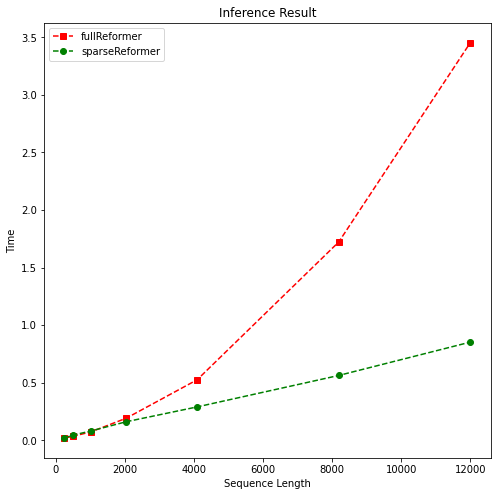

In [8]:
plotMe(results)

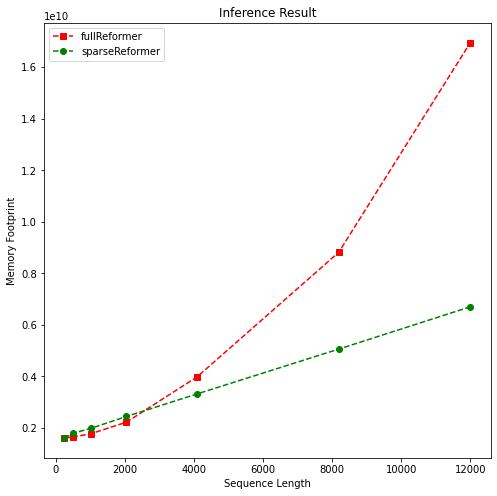

In [9]:
plotMe(results,"Memory Footprint")